In [32]:
# CELL 1 - Kütüphaneler ve Veri Yükleme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Stil ayarı (sunumda güzel dursun)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Kütüphaneler yüklendi.\n")

# Veri yükleme
df = pd.read_csv('data/raw/final_proje_dataset_CLEAN.csv')

print(f"Veri seti başarıyla yüklendi!")
print(f"Toplam satır: {df.shape[0]:,}")
print(f"Toplam sütun: {df.shape[1]}")
df.head()

Kütüphaneler yüklendi.

Veri seti başarıyla yüklendi!
Toplam satır: 11,060
Toplam sütun: 180


,date,/m/05p0rrx,/m/0108bn2x,/g/11tskkw5c9,/g/11sfdkgmfn,/g/11hcz1r4wl,/g/11pcs9ny8w,/g/11bw1zmnts,/m/0273t5w,/g/1234z6p9,...,/g/11jt20l831,/g/11h7_q3l6z,/g/11jp_j0m6d,/m/01h7lh,/m/0rfgxy2,/g/11ww08lq0j,/g/11vhqc7hb1,/m/02xz2,/m/0179v6,Country
0,2021-12-26,37,14,0,0,2,1,0,53,0,...,0,2,0,30,32,0.0,0.0,17.0,0.0,US
1,2022-01-02,47,18,0,0,2,2,0,70,0,...,0,4,0,27,19,0.0,0.0,16.0,0.0,US
2,2022-01-09,43,18,0,0,2,1,0,71,0,...,0,4,0,27,18,0.0,0.0,15.0,0.0,US
3,2022-01-16,49,18,0,0,2,1,0,70,0,...,0,4,0,30,13,0.0,0.0,13.0,0.0,US
4,2022-01-23,63,19,0,0,2,1,0,74,0,...,0,4,0,39,15,0.0,0.0,14.0,0.0,US


In [33]:
# CELL 2 - Temel Bilgiler
print("=== VERİ SETİ ÖZETİ ===\n")

# 1) Kaç tane feature (search term) var?
feature_columns = [col for col in df.columns if col not in ['date', 'Country']]
n_features = len(feature_columns)

print(f"1. Toplam feature (search term) sayısı: {n_features}")

# 2) Kaç farklı ülke var?
n_countries = df['Country'].nunique()

print(f"2. Toplam farklı ülke sayısı: {n_countries}")
print(f"   Ülkeler: {sorted(df['Country'].unique())}")

# 3) Tarih aralığı
df['date'] = pd.to_datetime(df['date'])
min_date = df['date'].min()
max_date = df['date'].max()
n_weeks = df['date'].nunique()

print(f"3. Zaman aralığı:")
print(f"   İlk tarih: {min_date.date()}")
print(f"   Son tarih: {max_date.date()}")
print(f"   Toplam hafta sayısı: {n_weeks}")
print(f"   Beklenen süre: ~3 yıl ({(max_date - min_date).days // 7 + 1} hafta)")

# Her ülke için ilk ve son tarih kontrolü
country_date_range = df.groupby('Country')['date'].agg(['min', 'max']).reset_index()
country_date_range['min'] = pd.to_datetime(country_date_range['min'])
country_date_range['max'] = pd.to_datetime(country_date_range['max'])
country_date_range['eksik_hafta_yok_mu'] = (country_date_range['min'] == min_date) & (country_date_range['max'] == max_date)

print(f"\n   Tüm ülkelerde tam veri var mı? {'EVET' if country_date_range['eksik_hafta_yok_mu'].all() else 'HAYIR'}")
if not country_date_range['eksik_hafta_yok_mu'].all():
    print("   Eksik veri olan ülkeler:")
    print(country_date_range[~country_date_range['eksik_hafta_yok_mu']][['Country', 'min', 'max']])

=== VERİ SETİ ÖZETİ ===

1. Toplam feature (search term) sayısı: 178
2. Toplam farklı ülke sayısı: 70
   Ülkeler: ['AE', 'AR', 'AT', 'AU', 'BD', 'BE', 'BG', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CZ', 'DE', 'DK', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GH', 'GR', 'HK', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IT', 'JP', 'KE', 'KR', 'LK', 'LT', 'LV', 'MA', 'MM', 'MX', 'MY', 'NG', 'NL', 'NO', 'NZ', 'PE', 'PH', 'PK', 'PL', 'PT', 'RO', 'RS', 'RU', 'SA', 'SE', 'SG', 'SI', 'SK', 'TH', 'TN', 'TR', 'TW', 'UA', 'US', 'UY', 'VE', 'VN', 'ZA']
3. Zaman aralığı:
   İlk tarih: 2021-12-26
   Son tarih: 2024-12-29
   Toplam hafta sayısı: 158
   Beklenen süre: ~3 yıl (158 hafta)

   Tüm ülkelerde tam veri var mı? EVET


In [34]:
import pandas as pd
import json
import re

# 1. JSON dosyasını ve Mapping (Eşleştirme) sözlüğünü yükle
def norm_label(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"[’']", "", s)
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", "_", s)
    return s

with open('data/raw/keywords_FINAL_2025.json', 'r', encoding='utf-8') as f:
    keyword_data = json.load(f)

# Topic ID -> Okunabilir Etiket eşleştirmesi oluştur
topic_to_label = {}
for cat in keyword_data['categories']:
    for sg in cat['sub_groups']:
        for q in sg['queries']:
            topic_to_label[q['topic_id']] = norm_label(q['label'])

# 2. Veriyi Hazırla
# Not: feature_columns listesinin sadece Topic ID'leri içerdiğinden emin ol
feature_columns = [col for col in df.columns if col not in ['date', 'Country']]

print("4. Her feature'ın kaç farklı ülkede ilgi gördüğü (skor > 10 olan ülke sayısı)\n")

# 3. Kapsam Analizini Yap (Dönüştürülmüş Etiketlerle)
feature_coverage = []

for col in feature_columns:
    # Bu feature'da skor >10 olan benzersiz ülke sayısını hesapla
    active_countries = df[df[col] > 5]['Country'].nunique()
    
    # Topic ID'yi okunabilir etikete çevir, yoksa ID olarak bırak
    label = topic_to_label.get(col, col)
    
    feature_coverage.append({
        'feature': label,
        'active_country_count': active_countries
    })

coverage_df = pd.DataFrame(feature_coverage)
coverage_df = coverage_df.sort_values('active_country_count', ascending=False).reset_index(drop=True)

# 4. Sonuçları Yazdır
print(f"   Global ilgi gören feature'lar (50+ ülkede >10 skor): {len(coverage_df[coverage_df['active_country_count'] >= 50])}")
print(f"   Orta ilgi (20-49 ülke): {len(coverage_df[(coverage_df['active_country_count'] >= 20) & (coverage_df['active_country_count'] < 50)])}")
print(f"   Niş / az ilgi (<20 ülke): {len(coverage_df[coverage_df['active_country_count'] < 20])}")
print(f"   Hiç ilgi görmeyen (0 ülke): {len(coverage_df[coverage_df['active_country_count'] == 0])}")

print("\n   En çok ilgi gören 10 feature:")
print(coverage_df.head(10)[['feature', 'active_country_count']].to_string(index=False))

print("\n   En az ilgi gören 10 feature:")
print(coverage_df.tail(10)[['feature', 'active_country_count']].to_string(index=False))

4. Her feature'ın kaç farklı ülkede ilgi gördüğü (skor > 10 olan ülke sayısı)

   Global ilgi gören feature'lar (50+ ülkede >10 skor): 76
   Orta ilgi (20-49 ülke): 45
   Niş / az ilgi (<20 ülke): 57
   Hiç ilgi görmeyen (0 ülke): 9

   En çok ilgi gören 10 feature:
       feature  active_country_count
       bitcoin                    70
patek_philippe                    70
   lamborghini                    70
       ferrari                    70
   gun_control                    70
        cartel                    70
      phishing                    70
     freelance                    70
    corruption                    70
        tinder                    70

   En az ilgi gören 10 feature:
          feature  active_country_count
  fentanyl_crisis                     1
 carbon_emissions                     0
             tofu                     0
 plant_based_diet                     0
            glp_1                     0
     electric_car                     0
   pirated_mo

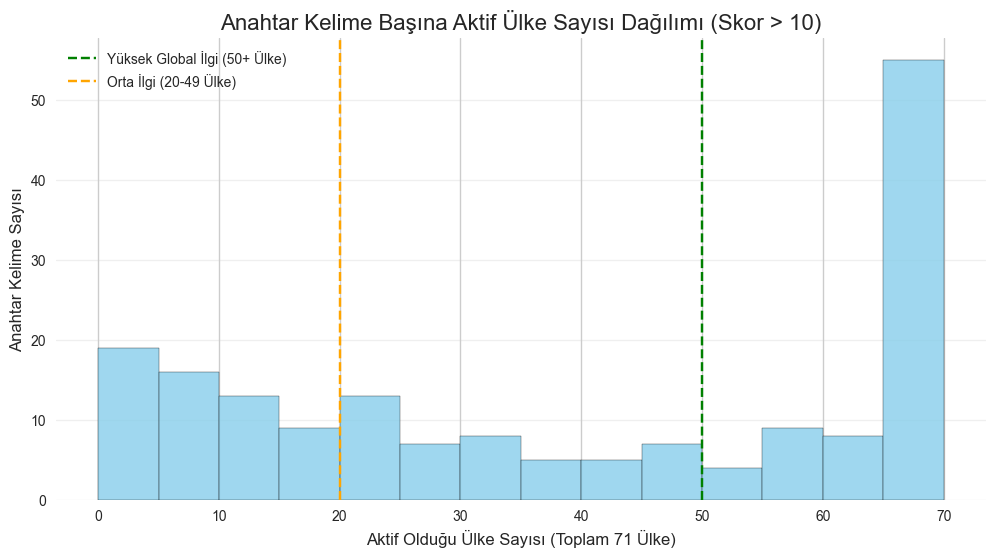

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Görselleştirme ayarları
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Histogram: coverage_df'deki aktif ülke sayılarını dağılım olarak göster
plt.hist(coverage_df['active_country_count'], bins=range(0, 72, 5), 
    color='skyblue', edgecolor='black', alpha=0.8)

plt.title('Anahtar Kelime Başına Aktif Ülke Sayısı Dağılımı (Skor > 10)', fontsize=16)
plt.xlabel('Aktif Olduğu Ülke Sayısı (Toplam 71 Ülke)', fontsize=12)
plt.ylabel('Anahtar Kelime Sayısı', fontsize=12)

# Referans çizgileri
plt.axvline(50, color='green', linestyle='--', label='Yüksek Global İlgi (50+ Ülke)')
plt.axvline(20, color='orange', linestyle='--', label='Orta İlgi (20-49 Ülke)')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [36]:
print("=== FEATURE TEMİZLEME (Aktif Ülke Sayısı >= 20) ===\n")

# 1. DataFrame Sütunlarını ID'den Etikete Çevir (Mapping)
# Bu adım çok önemli, temizlenmiş dosyanın okunabilir olmasını sağlar.
df_labeled = df.rename(columns=topic_to_label)

# 2. Threshold (Eşik): 20'den az ülkede aktif olanları belirle
threshold = 20
low_interest_labels = coverage_df[coverage_df['active_country_count'] < threshold]['feature'].tolist()
high_interest_labels = coverage_df[coverage_df['active_country_count'] >= threshold]['feature'].tolist()

print(f"Eşik Değeri: En az {threshold} ülkede skor > 10 olmalı.")
print(f"Kalan Feature Sayısı: {len(high_interest_labels)} (Önceki: {len(feature_columns)})")
print(f"Elenen Feature Sayısı: {len(low_interest_labels)}")
print(f"Kalan Feature Oranı: %{(len(high_interest_labels) / len(feature_columns) * 100):.1f}")

# 3. Temizlenmiş DataFrame Oluştur
# Sadece tarih, ülke ve yüksek ilgi gören etiketli sütunları alıyoruz.
df_cleaned = df_labeled[['date', 'Country'] + high_interest_labels].copy()

print(f"\nYeni DataFrame Yapısı: {df_cleaned.shape[0]} satır, {df_cleaned.shape[1]} sütun")

# 4. Temizlenmiş veriyi kaydet
df_cleaned.to_csv('data/raw/final_proje_dataset_CLEANED_features.csv', index=False)
print("\n[OK] Temizlenmiş ve Etiketlenmiş Veri Kaydedildi: final_proje_dataset_CLEANED_features.csv")

=== FEATURE TEMİZLEME (Aktif Ülke Sayısı >= 20) ===

Eşik Değeri: En az 20 ülkede skor > 10 olmalı.
Kalan Feature Sayısı: 121 (Önceki: 178)
Elenen Feature Sayısı: 57
Kalan Feature Oranı: %68.0

Yeni DataFrame Yapısı: 11060 satır, 123 sütun

[OK] Temizlenmiş ve Etiketlenmiş Veri Kaydedildi: final_proje_dataset_CLEANED_features.csv


In [37]:
print("=== SUNUM İÇİN GÜNCELLENMİŞ ÖZET TABLO ===\n")

# Tarih formatlarını kontrol et
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
min_date = df_cleaned['date'].min()
max_date = df_cleaned['date'].max()

summary_data = {
    'Özellik': [
        'Ham Verideki Toplam Kelime',
        'Analize Dahil Edilen Kelime (>=20 Ülke)',
        'Elenen Niş Kelime Sayısı',
        'Toplam Analiz Edilen Ülke',
        'Zaman Aralığı',
        'Toplam Gözlem (Hafta)',
        'Yüksek Global İlgi (50+ Ülke)',
        'Orta-Yüksek İlgi (20-49 Ülke)'
    ],
    'Değer': [
        len(feature_columns),
        len(high_interest_labels),
        len(low_interest_labels),
        df_cleaned['Country'].nunique(),
        f"{min_date.date()} → {max_date.date()}",
        df_cleaned['date'].nunique(),
        len(coverage_df[coverage_df['active_country_count'] >= 50]),
        len(coverage_df[(coverage_df['active_country_count'] >= 20) & (coverage_df['active_country_count'] < 50)])
    ]
}

updated_summary = pd.DataFrame(summary_data)
print(updated_summary.to_string(index=False))

=== SUNUM İÇİN GÜNCELLENMİŞ ÖZET TABLO ===

                                Özellik                   Değer
             Ham Verideki Toplam Kelime                     178
Analize Dahil Edilen Kelime (>=20 Ülke)                     121
               Elenen Niş Kelime Sayısı                      57
              Toplam Analiz Edilen Ülke                      70
                          Zaman Aralığı 2021-12-26 → 2024-12-29
                  Toplam Gözlem (Hafta)                     158
          Yüksek Global İlgi (50+ Ülke)                      76
          Orta-Yüksek İlgi (20-49 Ülke)                      45
